In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from PIL import Image
import os
import shutil

id = {	0: "Top", 	1: "Trouser", 	2: "Pullover", 	3: "Dress", 4: "Coat", 
		5: "Sandal", 6: "Shirt", 	7: "Sneaker", 	8: "Bag", 	9: "Boot"  }

print(f"PyTorch Version: {torch.__version__}, CUDA Version: {torch.version.cuda}, CUDA Enabled: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Normalize the data such that pixel values are floats in [0, 1]
transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0,), (1,))	# Pretty sure this is the default, but just to be safe
])

# Load training dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
# Split training data into training and validation sets, 12000 samples for validation
validation_size = 12000
train_size = len(train_dataset) - validation_size
train_indices = list(range(train_size))
val_indices = list(range(train_size, len(train_dataset)))
train_data = Subset(train_dataset, train_indices)
val_data = Subset(train_dataset, val_indices)
# Load test dataset
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
print(f"Training set size: {len(train_data)}, Validation set size: {len(val_data)}, Test set size: {len(test_dataset)}")

# Dataloaders for training, validation, and test sets, 32 observations per batch
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the convolutional neural network model
class CNN(nn.Module):
	def __init__(self):
		super(CNN, self).__init__()
		# 2D convolutional layers
		self.layer1 = nn.Sequential(    
			nn.Conv2d(in_channels=1, out_channels=28, kernel_size=3, padding=1),	# 1 input channel, 28 filters, 3x3 window size
			nn.ReLU(),																# ReLU activation
			nn.MaxPool2d(kernel_size=2, stride=1, padding=0)						# 2x2 max pooling
		)
		self.layer2 = nn.Sequential(
			nn.Conv2d(in_channels=28, out_channels=56, kernel_size=3, padding=1),	# 28 input channels, 56 filters, 3x3 window size
			nn.ReLU(),																# ReLU activation
		)
		# Fully connected layers
		self.fc1 = nn.Linear(56 * 27 * 27, 56)		# 56x7x7 input nodes, 56 output nodes
		self.relu = nn.ReLU()						# ReLU activation
		self.fc2 = nn.Linear(56, 10)				# 56 input nodes, 10 output nodes

	# Forward pass
	def forward(self, x):
		x = self.layer1(x)			# Pass through first convolutional layer
		x = self.layer2(x)			# Pass through second convolutional layer
		x = x.view(x.size(0), -1)	# Flatten the output from the convolutional layers
		x = self.relu(self.fc1(x))	# Pass through first fully connected layer with ReLU activation
		x = self.fc2(x)				# Pass through second fully connected layer
		return x

# Initialize the model, sparse categorical cross-entropy loss function, and Adam optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()	# Applys softmax activation and NLL loss on input
optimizer = optim.Adam(model.parameters(), lr=0.001)

PyTorch Version: 2.3.0+cu121, CUDA Version: 12.1, CUDA Enabled: True
Training set size: 48000, Validation set size: 12000, Test set size: 10000


In [45]:
# Used to track training and validation accuracies across epochs
train_accuracies = []
val_accuracies = []
losses = []
num_epochs = 10
for epoch in range(num_epochs): # Train the model for 10 epochs
	# Training Phase
	model.train()
	running_loss = 0.0
	correct_train = 0
	total_train = 0
	for inputs, labels in train_loader:
		inputs, labels = inputs.to(device), labels.to(device)	# Move data to GPU if available
		optimizer.zero_grad()									# Zero the parameter gradients
		outputs = model(inputs)									# Forward pass
		loss = criterion(outputs, labels)						# Compute loss
		loss.backward()											# Backward pass
		optimizer.step()										# Optimize the model

		_, predicted = torch.max(outputs.data, 1)			# Get predicted labels
		total_train += labels.size(0)						# Track total observations
		correct_train += (predicted == labels).sum().item() # Track correct predictions
		running_loss += loss.item()							# Track running loss
	losses.append(running_loss)								# Track loss across epochs
	train_accuracy = 100 * correct_train / total_train		# Training accuracy
	
	# Validation Phase
	model.eval()
	correct_val = 0
	total_val = 0
	for inputs, labels in val_loader:
		inputs, labels = inputs.to(device), labels.to(device)	# Move data to GPU if available
		outputs = model(inputs)									# Forward pass
		_, predicted = torch.max(outputs.data, 1)				# Get predicted labels
		total_val += labels.size(0)								# Track total observations
		correct_val += (predicted == labels).sum().item()		# Track correct predictions
	val_accuracy = 100 * correct_val / total_val				# Validation accuracy

	train_accuracies.append(train_accuracy)
	val_accuracies.append(val_accuracy)
	print(f"Epoch {epoch+1}: Loss = {running_loss:.3f}, Train Accuracy = {train_accuracy:.2f}%, Val Accuracy = {val_accuracy:.2f}%")
torch.save(model.state_dict(), 'model.pth') # Save the model, run it in the future with model.load_state_dict(torch.load('model.pth'))

Epoch 1: Loss = 608.401, Train Accuracy = 85.54%, Val Accuracy = 89.86%
Epoch 2: Loss = 381.784, Train Accuracy = 90.77%, Val Accuracy = 90.15%
Epoch 3: Loss = 302.214, Train Accuracy = 92.56%, Val Accuracy = 90.03%
Epoch 4: Loss = 245.328, Train Accuracy = 94.01%, Val Accuracy = 91.84%
Epoch 5: Loss = 196.626, Train Accuracy = 95.22%, Val Accuracy = 92.03%
Epoch 6: Loss = 154.370, Train Accuracy = 96.09%, Val Accuracy = 91.76%
Epoch 7: Loss = 119.448, Train Accuracy = 96.96%, Val Accuracy = 91.62%
Epoch 8: Loss = 92.972, Train Accuracy = 97.71%, Val Accuracy = 91.02%
Epoch 9: Loss = 72.195, Train Accuracy = 98.24%, Val Accuracy = 91.58%
Epoch 10: Loss = 55.098, Train Accuracy = 98.63%, Val Accuracy = 91.40%


In [46]:
# Evaluate on test set
correct_test = 0
total_test = 0
test_examples = {}
model.eval()
with torch.no_grad():										# Disable gradient tracking for evaluation
	for inputs, labels in test_loader:						# Iterate over test set
		inputs, labels = inputs.to(device), labels.to(device)	# Move data to the same device as the model
		outputs = model(inputs)								# Forward pass
		_, predicted = torch.max(outputs.data, 1)			# Get predicted labels
		total_test += labels.size(0)						# Track total observations
		correct_test += (predicted == labels).sum().item()	# Track correct predictions
		for i, pred in enumerate(predicted):				# Track misclassified examples
			if labels[i] not in test_examples and pred != labels[i]:
				test_examples[labels[i].item()] = (inputs[i], pred, labels[i])
test_accuracy = 100 * correct_test / total_test				# Test accuracy

# Save misclassified examples
shutil.rmtree("misclassified")
os.makedirs("misclassified")
for label, (img, pred, true_label) in test_examples.items():
	if pred != true_label:
		img_path = f"misclassified/True{id[true_label.item()]}_Pred{id[pred.item()]}_{label}.png"
		Image.fromarray(img.squeeze().cpu().numpy() * 255).convert('L').save(img_path)

# Model performance evaluation
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("============Model Performance===========")
print(f"Number of Trainable Parameters: {trainable_params}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Number of Misclassified Examples: {len(test_examples)}")

============Model Performance===========
Number of Trainable Parameters: 2301218
Test Accuracy: 91.57%
Number of Misclassified Examples: 10


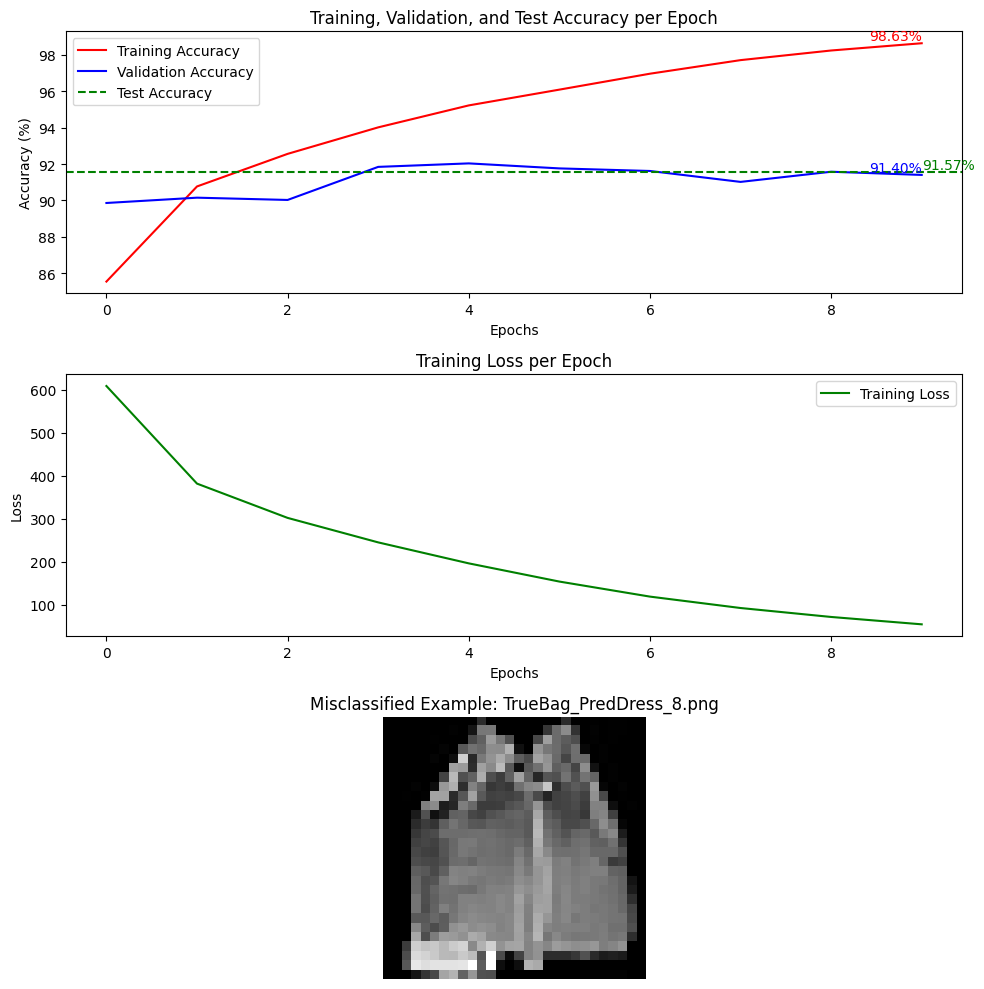

Misclassifications saved in 'misclassified' directory are understandable as they may be difficult to classify even for humans,
or contain features that are representative of either class. Additionally, I made the recent discovery that one should not 
Maxpool after the second convolutional layer, as it reduces the spatial dimensions of the data too much, causing a reduction 
in training accuracy somehow. Unsure why, but it is interesting. Furthermore, I previously had my stride size set to 2, but 
after migrating to a stride size of 1, the model performed better. This makes sense as a stride size of 2 would reduce the 
amount of features/overlapping features that get fed through the network, potentially decreasing learnability.


In [47]:
# Evaluate training and validation accuracy at the end of each epoch, and plot them as line plots
plt.figure(figsize=(num_epochs, 10))
plt.subplot(3, 1, 1)
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy', color='red')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy', color='blue')
plt.axhline(y=test_accuracy, color='green', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training, Validation, and Test Accuracy per Epoch')
plt.text(num_epochs-1, train_accuracy, f"{train_accuracy:.2f}%", ha='right', va='bottom', color='red')
plt.text(num_epochs-1, val_accuracy, f"{val_accuracy:.2f}%", ha='right', va='bottom', color='blue')
plt.text(num_epochs-1, test_accuracy, f"{test_accuracy:.2f}%", ha='left', va='bottom', color='green')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(range(num_epochs), losses, label='Training Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()

listdir = os.listdir('misclassified')
filename = listdir[0] if listdir else None
image = plt.imread(f'misclassified/{filename}')
plt.subplot(3, 1, 3)
plt.title(f"Misclassified Example: {filename}")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

print("""Misclassifications saved in 'misclassified' directory are understandable as they may be difficult to classify even for humans,
or contain features that are representative of either class. Additionally, I made the recent discovery that one should not 
Maxpool after the second convolutional layer, as it reduces the spatial dimensions of the data too much, causing a reduction 
in training accuracy somehow. Unsure why, but it is interesting. Furthermore, I previously had my stride size set to 2, but 
after migrating to a stride size of 1, the model performed better. This makes sense as a stride size of 2 would reduce the 
amount of features/overlapping features that get fed through the network, potentially decreasing learnability.""")